In [5]:
#%%

# path to working directory
path = '/Users/davidnordfors/galvanize/galvanize-capstone/final'


# IMPORT LIBRARIES
## OS
import os
os.chdir(path)

# MANAGE
import pandas as pd
import numpy as np

## FIT
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xgb

from sklearn.metrics import r2_score

## DECOMPOSITION
from sklearn.decomposition import NMF
# from scipy.linalg import svd

## GRAPHICS
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

## I/O
import zipfile
import requests
import pickle

## FUNCTIONS AND CLASSES

# Normalization function
def norm(vec):
    '''
    Normalizes a vector v-v.mean())/v.std() - works for: PandasDataFrame.apply(norm)
    '''
    return (vec-vec.mean())/vec.std()

def nrmcol(df):
    '''
    Normalizes the columns of a DataFrame (cos distance)
    '''
    return df / np.sqrt(np.diagonal(df.T @ df))

# format and Strip O*NET SOC occupation codes to match the ones used by Census PUMS
def soc(socpnr,shave=5):
    '''
    Key function 
        1. formats SOC-occupation codes – for matching O*Net and census.
        2. 'Shaves' the SOC-number to length 'shave'. The number sets the granularity of job classifications. 
    '''
    socpnr2 = str(socpnr).replace('-','')
    socp_shave = socpnr2[:shave]
    return socp_shave


#
class   Onet:
    def __init__(self,features):
        self.features = features
        self.data = self.get_data()
        self.matrix = self.construct_matrix()
        self.nmatrix = self.matrix.apply(lambda x: (x-x.min())/(1+ x.max()))

        
    # READ FROM O*NET DATABASE. 
    database = {}
    def get_data(self):
        '''
        READ O*NET DATABASE. Search order: Dictionary, Pickle, Excel; Create dictionary/pickle if non-existent.
        '''
        onet = Onet.database
        if type(self) == Onet:
            featureset = self.features
        else:
            featureset = self
        if featureset in onet:
                return onet[featureset]
        pickle_exists = os.path.isfile('./data/pickle/'+featureset+'.pkl')
        if pickle_exists:
                onet[featureset] = pd.read_pickle('./data/pickle/'+featureset+'.pkl')
                return onet[featureset]
        else: 
                onet[featureset]= pd.read_excel(
                        zipfile.ZipFile('./data/db_23_2_excel.zip').extract(
                        'db_23_2_excel/'+featureset+'.xlsx'))
                onet[featureset].to_pickle('./data/pickle/'+featureset+'.pkl')
                return onet[featureset]
    
   
    def construct_matrix(self):
        '''
        Reshapes O*NET occupation/feature matrix to a regular matrix of N_occupations x M_features. Used as X for fitting. 
        '''
        prepdata = self.prepare()
        foo = pd.get_dummies(prepdata['Element Name']) 
        occ_prepdata = prepdata[['O*NET-SOC Code']].join(foo.multiply(prepdata['Data Value'],axis = "index")).groupby('O*NET-SOC Code').sum()
        occ_prepdata['SOCP'] = occ_prepdata.index
        occ_prepdata['SOCP_shave']=occ_prepdata['SOCP'].apply(soc)
        # Group by census/PUMS SOC codes (SOCP_shave)
        occ_prepdata_compounded= occ_prepdata.groupby('SOCP_shave').mean()
        occ_prepdata_compounded['SOCP_shave'] = occ_prepdata_compounded.index   
        foo = occ_prepdata_compounded.drop(columns='SOCP_shave')
        return foo
  
    def prepare(self):
        '''
        Preprocesses O*Net data for shaping the features x occupations matrix (used as X)
        '''
        df = self.data
        # For Abilities, Knowledge, Skills
        if 'LV' in set(df['Scale ID']):
            sid = 'LV'
        # For Interests
        elif 'OI' in set(df['Scale ID']):
            sid = 'OI'
        df = df[df['Scale ID'] == sid]
        return df[['O*NET-SOC Code','Element Name','Data Value']] 

onet_titles = Onet.get_data('Alternate Titles')
all_SOCP = set(onet_titles['O*NET-SOC Code'])
onet_title_dic = onet_titles[['O*NET-SOC Code','Title']].copy()
onet_title_dic['O*NET-SOC Code'] = onet_title_dic['O*NET-SOC Code'].apply(soc)
onet_socp_name = dict(onet_title_dic.values).get



class   Census:
    '''
    Census is an object containing census ACS/PUMS data for a state (Default = California)
    The original data is read from a pickle file in 'data/pickle/pums_'+state+'.pkl'
    
    my_census.state    – String: name of state, e.g. 'California'
    my_census.data     – DataFrame: imported census ACS/PUMS data (from pickle)
    my_census.workers  – DataFrame: people fulfilling 'workers' criteria (see below)
    my_census.occupations         – DataFrame: Occupations of the workers (groupby SOCP-number)
    
    my_census.workers_occupations(age_low = 40, age_high = 65, std_max = 0.5, socp_granularity = 5):
         - Function: populates my_census.workers / .occupations according to criteria
             – Workers: age_low (default 40)  and age_high (default 65)
             – Occupations: socp_granularity (default 5) ; the length of the SOCP number, default 5 digits.
    
    '''

    def __init__(self,state = 'California'):
        self.state = state
        self.data = pd.read_pickle('data/pickle/pums_'+state+'.pkl')
        self.workers_occupations()

    def workers_occupations(self,age_low = 40, age_high = 65, std_max = 0.5, socp_granularity = 5, dear = False, deye = False):
        '''
        Defines workers as people between ages 'age_low'(default 40) and 'age_high' (default 65)
        Defines occupations as the occupations of these workers, with a granularity of 5 digits in the SOCP number 
        '''
        self.workers = self.data[
                            (self.data['AGEP'] >= age_low) &
                            (self.data['AGEP'] <= age_high) 
                        ].copy()
        if dear:
            self.workers = self.workers[self.workers['DEAR']==1]
        if deye:
            self.workers = self.workers[self.workers['DEYE']==1]
        self.workers['log FTE'] = self.workers['FTE wage'].apply(np.log)
        self.workers['SOCP_shave'] = self.workers['SOCP'].apply(lambda socpnr: soc(socpnr,socp_granularity))
        foo = self.workers.groupby('SOCP_shave')
        self.occupations = foo.mean()[['AGEP', 'FTE wage','log FTE']]
        self.occupations['count'] = foo.count()['AGEP']
        self.occupations['std log FTE'] = foo.std()['log FTE']
        self.occupations['Occupation'] = self.occupations.index
    
    # Census Data Dictionary
    datadic = pd.read_csv("./data/PUMS_Data_Dictionary_2017.csv").drop_duplicates()
        
    # Data Dictionary rows including the string 'word'
    def var_about(word):
        '''
        Census Data dictionary: records containing the string 'word' 
        '''
        datadic = Census.datadic
        return pd.concat((datadic[datadic['Record Type'].apply(lambda x: word.lower() in str(x).lower())],
                      datadic[datadic['Unnamed: 6'].apply(lambda x: word.lower() in str(x).lower())]))

    # Name of occupation for SOCP number
    def socp_name(socp):
        '''
        Census Data dictionary: Name of the occupation(s) corresponding to the input SOCP number 
        '''
        datadic = Census.datadic
        return datadic[datadic['Record Type']== str(socp)]['Unnamed: 6'].values[0]

## OBJECT-ORIENTED FITTING 
class Xfit:
    '''
    Xfit is a 'fit-as-an-object' solution:
        my_fit = Xfit(X,y, my_regressor, itr, xval) 
            does the following:
            1. SPLITS X and y into test and training sets.
            2. FITS a cross-validation, slicing the training data into 'xval' slices : cross_validate(regressor,X_train.values, y_train.values, cv=xval) 
            3. BOOTSTRAPS: Repeats (1-2) 'itr' number of times
            4. RETURNS RESULTS as attributes:
                my_fit.X          – List: The original X input data
                my_fit.itr        – Number of iterations / fits
                my_fit.y          – List: The original y input data
                my_fit.xval       – Number of slices in the cross validation
                my_fit.fit        – Dictionary: the 'itr' number of cross-validated fits, including estimators
                my_fit.y_test     – Dictionary: the y_test (list) for each fit
                my_fit.y_predict  – Dictionary: the predicted y for each fit
                my_fit.scores     – Pandas.DataFrame: validation scores for all fits 
                my_fit.score      – Dictionary: the mean score and standard deviation. 
                my_fit.features_importances        – Dictionary: feature_importances for all fits (for estimators with '.feature_importance_' as an attribute )
                my_fit.feature_importance          – Pandas.DataFrame: the average feature importances and standard deviations.           
    '''
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import cross_val_score
    from sklearn import linear_model
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.metrics import r2_score
    import xgboost as xgb  

    def __init__(self,X,y,regressor = xgb.XGBRegressor(),itr = 10, xval = 3):      
        # FITTING
        n = xval  
        feature_names = X.columns
        res = {}
        ypred = {}
        ytest = {}
        scor = {}
        feat_imp = {}       
        for i in range(itr):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
            res_xboo = cross_validate(regressor,X_train.values, y_train.values, cv=n, return_estimator=True)
            ytest[i] = y_test
            res[i] = res_xboo
            ypred[i] = [res_xboo['estimator'][j].predict(X_test.values) for j in range(n)]
            scor[i] = [res_xboo['estimator'][j].score(X_test.values,y_test.values) for j in range(n)]
            feat_imp[i] = [res_xboo['estimator'][j].feature_importances_ for j in range(n)]
        scor_tot = np.concatenate(np.array(list(scor.values())))
        feat_tot = pd.concat([pd.DataFrame(feat_imp[i]) for i in range(itr)])
        feat_tot.columns = X.columns
        feat_tot.reset_index(inplace=True,drop = True)
        feat_mean = pd.concat([feat_tot.mean(),feat_tot.std()],axis=1)
        feat_mean.columns = ['mean','std']
        feat_mean['ratio'] = feat_mean['std']/feat_mean['mean']      
        # STORING RESULTS AS ATTRIBUTES
        self.X = X
        self.y = y
        self.fit = res
        self.y_predict = ypred
        self.y_test = ytest
        #self.r2scor = r2_score(ytest,ypred)
        self.scores = pd.DataFrame(scor).T
        self.score = {'mean':scor_tot.mean(), 'std':scor_tot.std()}
        self.feature_importances = feat_imp
        self.feature_importance = feat_mean.sort_values('mean',ascending=False)
        self.itr =itr
        self.xv = xval

## MATRIX-FACTORIZATION: DIMENSIONALITY REDUCTION & ARCHETYPING

# CLUSTER FEATURES INTO OCCUPATION CATEGORIES
# Use non-zero matrix factorization for clustering
# Use singular value decomposition first state for determining overall similarity

class Archetypes:
    '''
    Archetypes: Performs NMF of order n on X and stores the result as attributes. 
    Archetypes are normalized: cosine similarity a(i) @ a(i) = 1. 
    Atributes:
        my_archetypes.n         - order / number of archetypes
        my_archetypes.X         - input matrix
        
        my_archetypes.model     - NMF model 
        my_archetypes.w         - NMF w-matrix 
        my_archetypes.h         - NMF h-matrix
        
        my_archetypes.o         - occupations x archetypes matrix (from w-matrix)
        my_archetypes.on        - occupations x normalized archetypes matrix (from w-matrix) - SOCP number as index. 
        my_archetypes.occ       - occupations x normalized archetypes matrix - Occupation names as index
        
        my_archetypes.f         - features x archetypes matrix (from h-matrix)
        my_archetypes.fn        - features x normalized archetypes matrix
        
    '''
    def __init__(self,X,n):
        self.n = n
        self.X = X
        self.model = NMF(n_components=n, init='random', random_state=0, max_iter = 1000, tol = 0.0000001)
        self.w = self.model.fit_transform(self.X)
        self.o = pd.DataFrame(self.w,index=self.X.index)
        self.on = nrmcol(self.o.T).T
        self.occ = self.on.copy()
        self.occ['Occupations'] = self.occ.index
        self.occ['Occupations'] = self.occ['Occupations'].apply(onet_socp_name)
        self.occ = self.occ.set_index('Occupations')
        self.h = self.model.components_
        self.f = pd.DataFrame(self.h,columns=X.columns)
        self.fn = nrmcol(self.f.T).T
        
    def plot_features(self,fig_scale = (1,3.5),metric='cosine', method = 'single'): 
        '''
        Plot Archetypes as x and features as y. 
        Utilizes Seaborn Clustermap, with hierarchical clustering along both axes. 
        This clusters features and archetypes in a way that visualizes similarities and diffferences
        between the archetypes. 
        
        Archetypes are normalized (cosine-similarity): dot product archetype[i] @ archetype[i] = 1.
        The plot shows intensities (= squared feature coefficients) so that the sum of intensities = 1.  

        fig_scale: default values (x/1, y/3.5) scales the axes so that all feature labels are included in the plot.
        
        For other hyperparameters, see seaborn.clustermap
     
        '''
        sns.clustermap(np.square(self.fn),robust = True, z_score=0,figsize=(
            self.X.shape[1]/fig_scale[1],self.n/fig_scale[0]),method = method,metric = metric)


    def plot_occupations(self,fig_scale = (1,3.5),metric='cosine', method = 'single'):
        '''
        Plot Archetypes as x and occupations as y. 
        Utilizes Seaborn Clustermap, with hierarchical clustering along both axes. 
        This clusters occupations and archetypes in a way that visualizes similarities and diffferences
        between the archetypes. 
        
        Occupations are normalized (cosine-similarity): dot product occupation[i] @ occupation[i] = 1.
        The plot shows intensities (= squared feature coefficients) so that the sum of intensities = 1.  

        fig_scale: default values (x/1, y/3.5) scales the axes so that all feature labels are included in the plot.
        
        For other hyperparameters, see seaborn.clustermap
     
        '''   
        sns.clustermap(np.square(self.occ).T, figsize=(
            self.X.shape[0]/fig_scale[1],self.n/fig_scale[0]),method = method,metric = metric)


# class Svd:
#     ''''
#     Singular value decomposition-as-an-object
#         my_svd = Svd(X) returns
#         my_svd.u/.s/.vt – U S and VT from the Singular Value Decomposition (see manual)
#         my_svd.f        – Pandas.DataFrame: features x svd_features
#         my_svd.o        - Pandas.DataFrame: occupations x svd_features
#     '''
#     def __init__(self,X):
#         self.u,self.s,self.vt = svd(np.array(X))
#         self.f = pd.DataFrame(self.vt,columns=X.columns)
#         self.o = pd.DataFrame(self.u,columns=X.index)
        


#%%
if __name__ == "__main__":      
# # 
# OCCUPATIONAL ARCHETYPES 
# Purpose: A tool for people and organizations to discuss, analyze, predict, strategize on the job market. 
#
# Data Sources:
# - Occupation data: O*NET
# - People data: Census ACS/PUMS
#
# ## What this codes does
# - Creates occupational archetypes from a matrix of occupations and festures (abilities, skills, knowledge, etc.)
# - Selects a demography from census
# - Calculates labor market statistics, economic indicators for the archetypes with regards to the demography
# - Evaluate the predictive power of the Archtypes: 
#       - select a target (yearly full-time equivalent wage)
#       - fit features to target: compare Archetypes vs original features.
# 



    ## CENSUS DATA
    # select workers in ages 40 - 65 and discard the occupations with large standard deviations.

    census = Census('California')

    ## ONET DATA

    ab = Onet('Abilities')

    ## ESTIMATORS
    
    xboo = xgb.XGBRegressor()

## More estimators to use:
#     rid = linear_model.Ridge(alpha=.5)
#     rf = RandomForestRegressor(n_estimators=40,
#                             max_features='auto',
#                             random_state=0)
#     boo = GradientBoostingRegressor(loss='ls', learning_rate=0.1, n_estimators=100, subsample=1.0, criterion='friedman_mse', min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_depth=3, min_impurity_decrease=0.0, min_impurity_split=None, init=None, random_state=None, max_features=None, alpha=0.9, verbose=0, max_leaf_nodes=None, warm_start=False, presort='auto', validation_fraction=0.1, n_iter_no_change=None, tol=0.0001)


In [6]:
census = Census('California')
ab = Onet('Abilities')
kn = Onet('Knowledge')
sk = Onet('Skills')
dall = pd.concat([ab.matrix,sk.matrix,kn.matrix],axis = 1)

Text(0.5,1,'O*NET DATABASE: ABILITIES REQUIRED BY OCCUPATIONS\n')

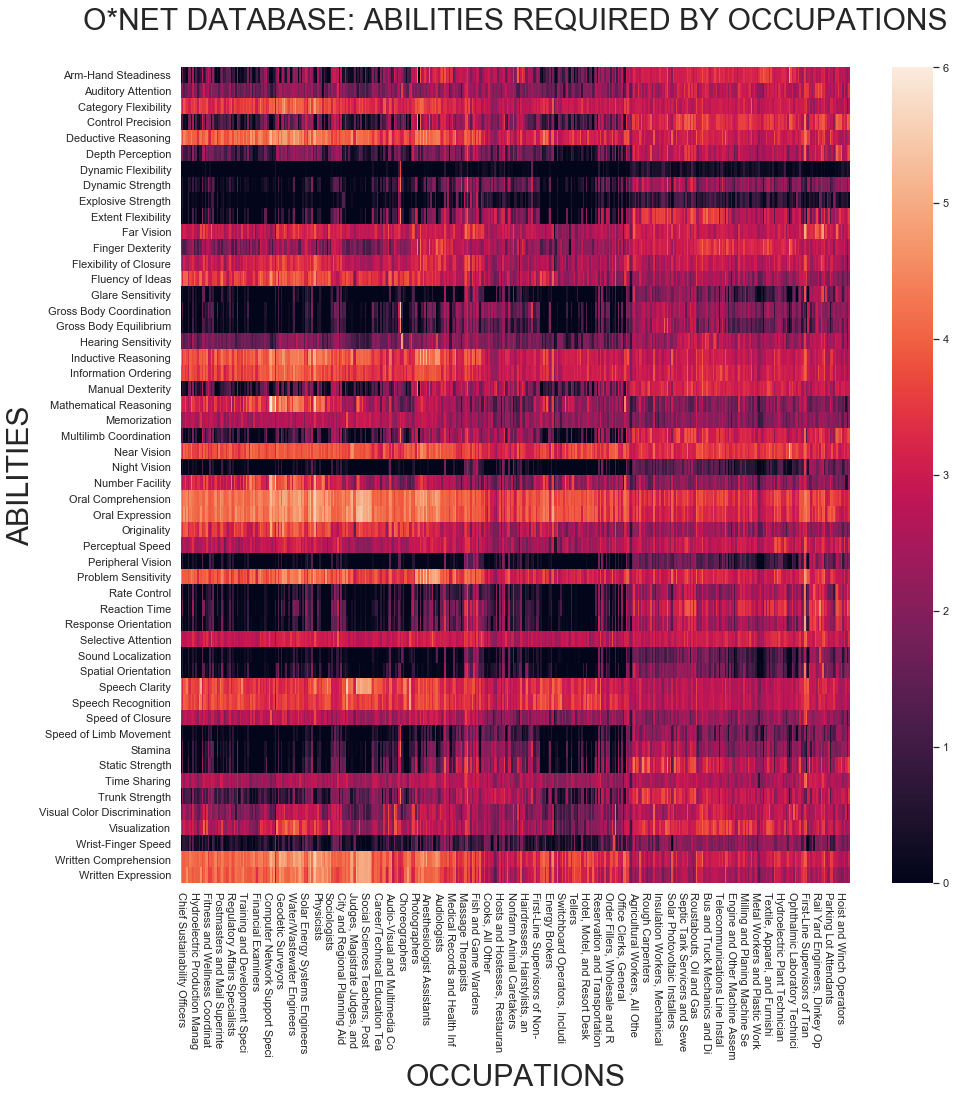

In [43]:
plt.figure(figsize = (15,15))
sns.heatmap(ab.matrix.T)
plt.xticks(rotation=-90)
plt.xlabel('OCCUPATIONS',fontsize = 30)
plt.ylabel('ABILITIES',fontsize = 30)
plt.title('O*NET DATABASE: ABILITIES REQUIRED BY OCCUPATIONS\n', fontsize = 30)

In [7]:
ab.nmatrix = ab.matrix.apply(lambda x: (x-x.min())/(1+ x.max()))

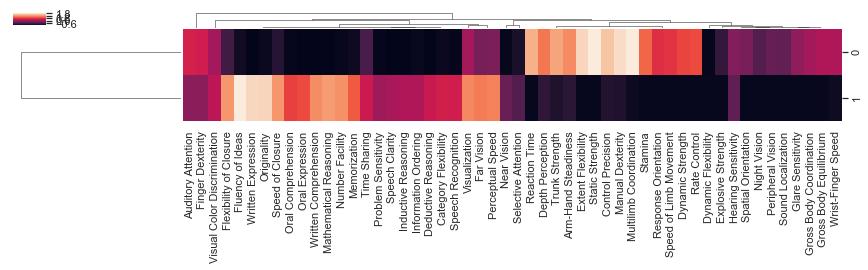

In [10]:
dab = Archetypes(ab.nmatrix,2)
dab.plot_features()

In [11]:
socp_counts = census.workers.groupby('SOCP_shave').count()[['RT']]

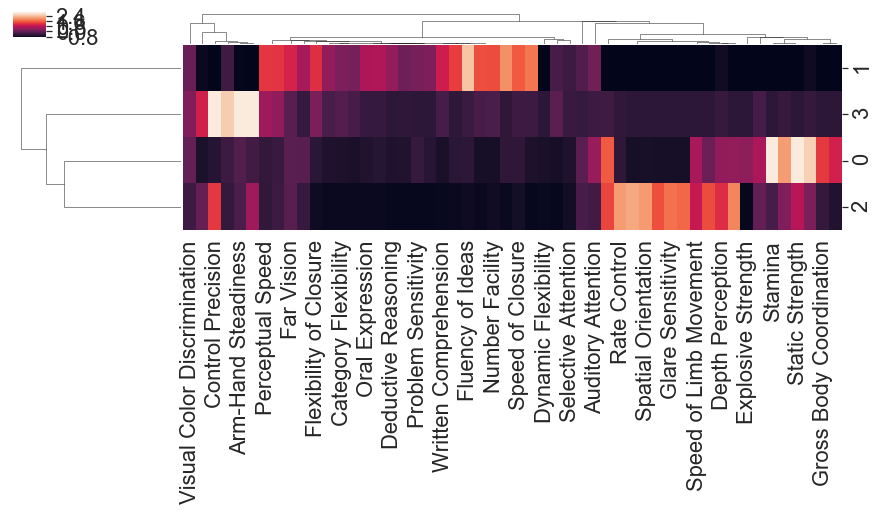

In [89]:
ab.matrixcnts = ab.nmatrix.merge(socp_counts,left_index = True,right_index = True)
ab.wmatrix = ab.matrixcnts.drop('RT',axis=1).multiply(ab.matrixcnts['RT'], axis="index")
dabwc = Archetypes(ab.wmatrix,4)
dabwc.plot_features()

In [14]:
1/np.sqrt(2)

0.7071067811865475

In [96]:
census.occupations.head()

,AGEP,FTE wage,log FTE,count,std log FTE,Occupation
SOCP_shave,,,,,,
11102,50.922698,101222.353254,11.306408,3247,0.631343,11102
1110X,52.469206,165114.959165,11.738277,5829,0.766755,1110X
11201,48.448598,114981.076711,11.412416,107,0.670089,11201
11202,49.995900,120147.041452,11.482138,3171,0.646643,11202
11203,50.689655,99462.363460,11.362763,203,0.518902,11203


In [97]:
dabwc.fte = census.workers.merge(np.square(dabwc.on),left_on="SOCP_shave",right_index=True)
dabwc.fte.head()

,RT,SERIALNO,DIVISION,SPORDER,PUMA,REGION,ST,ADJINC,PWGTP,AGEP,...,PWGTP78,PWGTP79,PWGTP80,FTE wage,log FTE,SOCP_shave,0,1,2,3
1,P,2013000000015,9,1,3702,4,6,1061971,7,63,...,8,8,3,336800.000000,12.727245,29112,0.528776,0.439366,0.01039,0.021469
2738,P,2013000011445,9,2,101,4,6,1061971,13,50,...,4,20,25,108333.333333,11.592968,29112,0.528776,0.439366,0.01039,0.021469
3624,P,2013000015040,9,2,5915,4,6,1061971,16,55,...,33,4,26,60800.000000,11.015345,29112,0.528776,0.439366,0.01039,0.021469
3796,P,2013000015779,9,1,6711,4,6,1061971,25,41,...,40,25,19,93000.000000,11.440355,29112,0.528776,0.439366,0.01039,0.021469
4217,P,2013000017507,9,1,3705,4,6,1061971,13,54,...,24,15,24,110666.666667,11.614278,29112,0.528776,0.439366,0.01039,0.021469


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'CALIFORNIA: WAGE STATISTICS FOR OCCUPATIONS')

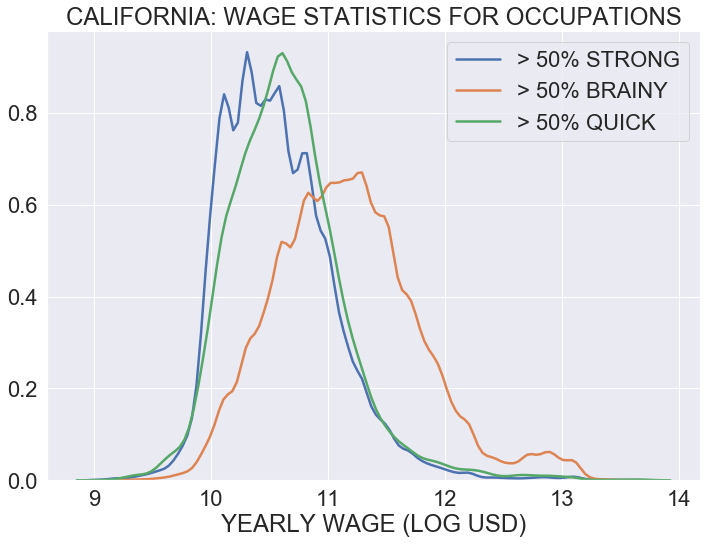

In [252]:
labs = {0: '> 50% STRONG', 1: '> 50% BRAINY', 2: '> 50% QUICK', 3: '> 50% HANDY'}

sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
[sns.distplot(dabwc.fte[dabwc.fte[i] > 0.7]['log FTE'],label = labs[i],rug = False, hist=False) for i in [0,1,2]]
plt.xlabel('YEARLY WAGE (LOG USD)')
plt.ylabel('')
plt.title('CALIFORNIA: WAGE STATISTICS FOR OCCUPATIONS')

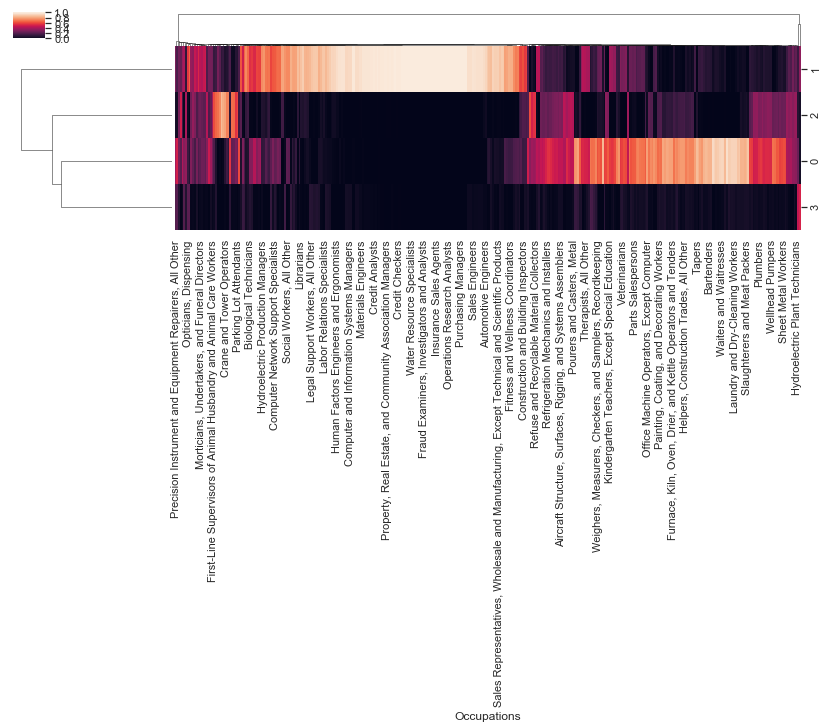

In [103]:
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})
dabwc.plot_occupations(fig_scale = (1,25))

In [239]:
nitr=100
n_arch = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,36,52]
#n_arch = [4,8]
arall = {}
arall_X = {}
arall_y = {} 
arall_xfit ={}
for n in n_arch:
    arall[n]=Archetypes(ab.wmatrix,n)
    arall_X[n] = arall[n].on.merge(census.occupations[['log FTE']],left_index = True,right_index = True)
    arall_y[n] = arall_X[n].pop('log FTE')
    arall_xfit[n] = Xfit(arall_X[n],arall_y[n],itr=nitr)

r2scores = pd.DataFrame([np.concatenate([pd.DataFrame(arall_xfit[n].y_predict[i]).T.apply(
    lambda ypred: r2_score(arall_xfit[n].y_test[i],ypred)) for i in range(nitr)]) for n in n_arch],
            index = n_arch).T
r2score = pd.DataFrame([r2scores.mean(),r2scores.std()],index = ['mean R^2 score','std']).T
r2score

,mean R^2 score,std
2,0.201052,0.112871
3,0.280995,0.117946
4,0.367853,0.111807
5,0.428048,0.099449
6,0.501274,0.096621
7,0.523291,0.079069
8,0.555248,0.077003
9,0.517596,0.079550
10,0.520287,0.099143
11,0.537174,0.079127


In [120]:
class RXfit:
    '''
    Xfit is a 'fit-as-an-object' solution:
        my_fit = Xfit(X,y, my_regressor, itr, xval) 
            does the following:
            1. SPLITS X and y into test and training sets.
            2. FITS a cross-validation, slicing the training data into 'xval' slices : cross_validate(regressor,X_train.values, y_train.values, cv=xval) 
            3. BOOTSTRAPS: Repeats (1-2) 'itr' number of times
            4. RETURNS RESULTS as attributes:
                my_fit.X          – List: The original X input data
                my_fit.itr        – Number of iterations / fits
                my_fit.y          – List: The original y input data
                my_fit.xval       – Number of slices in the cross validation
                my_fit.fit        – Dictionary: the 'itr' number of cross-validated fits, including estimators
                my_fit.y_test     – Dictionary: the y_test (list) for each fit
                my_fit.y_predict  – Dictionary: the predicted y for each fit
                my_fit.scores     – Pandas.DataFrame: validation scores for all fits 
                my_fit.score      – Dictionary: the mean score and standard deviation. 
                my_fit.features_importances        – Dictionary: feature_importances for all fits (for estimators with '.feature_importance_' as an attribute )
                my_fit.feature_importance          – Pandas.DataFrame: the average feature importances and standard deviations.           
    '''
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import cross_validate
    from sklearn.model_selection import cross_val_score
    from sklearn import linear_model
    from sklearn.ensemble import RandomForestRegressor
    from sklearn.ensemble import GradientBoostingRegressor
    import xgboost as xgb  

    def __init__(self,X,samplx,y,regressor = xgb.XGBRegressor(),itr = 10, xval = 3):      
        # FITTING
        n = xval  
        feature_names = X.columns
        res = {}
        ypred = {}
        ytest = {}
        scor = {}
        feat_imp = {}       
        for i in range(itr):
            X_train, X_test, y_train, y_test = train_test_split(X.sample(samplx,axis=1), y, test_size=0.2)
            res_xboo = cross_validate(regressor,X_train.values, y_train.values, cv=n, return_estimator=True)
            ytest[i] = y_test
            res[i] = res_xboo
            ypred[i] = [res_xboo['estimator'][j].predict(X_test.values) for j in range(n)]
            scor[i] = [res_xboo['estimator'][j].score(X_test.values,y_test.values) for j in range(n)]
            feat_imp[i] = [res_xboo['estimator'][j].feature_importances_ for j in range(n)]
        scor_tot = np.concatenate(np.array(list(scor.values())))
        feat_tot = pd.concat([pd.DataFrame(feat_imp[i]) for i in range(itr)])
#       # feat_tot.columns = X.columns
        feat_tot.reset_index(inplace=True,drop = True)
        feat_mean = pd.concat([feat_tot.mean(),feat_tot.std()],axis=1)
        feat_mean.columns = ['mean','std']
        feat_mean['ratio'] = feat_mean['std']/feat_mean['mean']      
        # STORING RESULTS AS ATTRIBUTES
        self.X = X
        self.y = y
        self.fit = res
        self.y_predict = ypred
        self.y_test = ytest
        self.scores = pd.DataFrame(scor).T
        self.score = {'mean':scor_tot.mean(), 'std':scor_tot.std()}
        self.feature_importances = feat_imp
        self.feature_importance = feat_mean.sort_values('mean',ascending=False)
        self.itr =itr
        self.xv = xval



In [237]:
nitr=100
n_arch = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,36,52]
rX = nrmcol(ab.wmatrix).merge(census.occupations[['log FTE']],left_index=True,right_index=True)
ry = rX.pop('log FTE')
xfit ={}
for n in n_arch:
    xfit[n] = RXfit(rX,n,ry,itr=nitr)

r2scores2 = pd.DataFrame([np.concatenate([pd.DataFrame(xfit[n].y_predict[i]).T.apply(
    lambda ypred: r2_score(xfit[n].y_test[i],ypred)) for i in range(nitr)]) for n in n_arch],
            index = n_arch).T
r2score2 = pd.DataFrame([r2scores2.mean(),r2scores2.std()],index = ['mean R^2 score','std']).T
r2score2

,mean R^2 score,std
2,0.007154,0.186162
3,0.089138,0.158081
4,0.157663,0.133365
5,0.197983,0.126411
6,0.189726,0.148523
7,0.203191,0.143503
8,0.224198,0.137216
9,0.241954,0.135388
10,0.250479,0.121301
11,0.267396,0.142406


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'PREDICTIVE POWER')

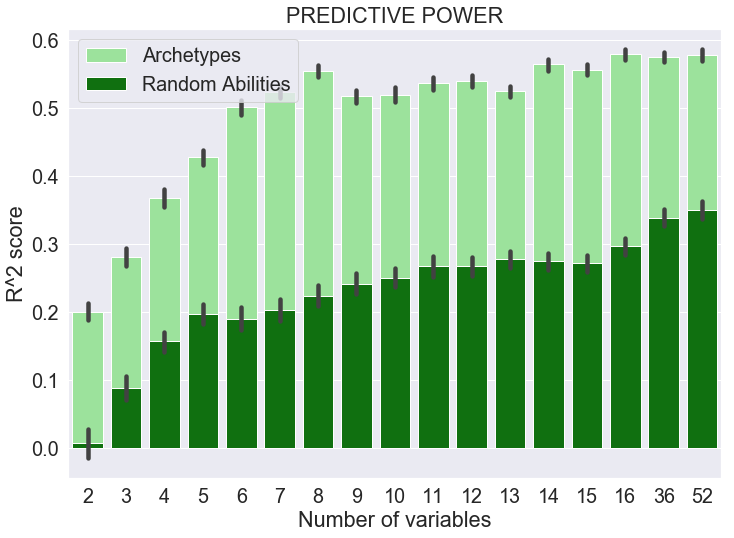

In [240]:
sns.set_context("notebook", font_scale=1.8, rc={"lines.linewidth": 2.5})
sns.barplot(data = r2scores,color = 'lightgreen',label = 'Archetypes')
sns.barplot(data = r2scores2,color = 'green', label = 'Random Abilities')
plt.legend()
plt.xlabel('Number of variables')
plt.ylabel('R^2 score')
plt.title('PREDICTIVE POWER')

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


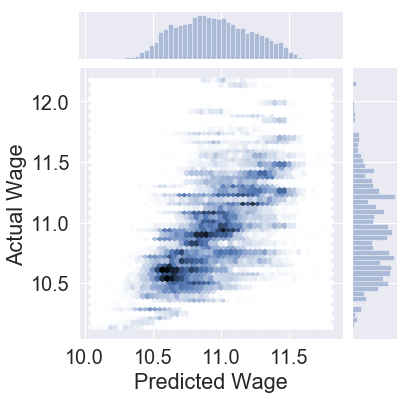

In [231]:
nn = 4
ypred = pd.concat([pd.DataFrame(arall_xfit[nn].y_predict[i]).T for i in range(100)])
ytest = np.concatenate([arall_xfit[nn].y_test[i].values for i in range(100)])
ypred['ytest'] = ytest
predactual_fte = pd.DataFrame(np.concatenate([ypred[[i,'ytest']].values 
                                              for i in range(3)]),columns = ['Predicted Wage','Actual Wage'])
sns.jointplot(x = 'Predicted Wage',y='Actual Wage',data= predactual_fte,kind='hex')

In [232]:
nitr=100
# n_arch = [2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,36,52]
n_arch = [4,8]
arall = {}
arall_X = {}
arall_y = {} 
arall_xfit ={}
for n in n_arch:
    arall[n]=Archetypes(ab.wmatrix,n)
    arall_X[n] = arall[n].on.merge(census.occupations[['log FTE']],left_index = True,right_index = True)
    arall_y[n] = arall_X[n].pop('log FTE')
    arall_xfit[n] = Xfit(arall_X[n],arall_y[n],itr=nitr)

r2scores = pd.DataFrame([np.concatenate([pd.DataFrame(arall_xfit[n].y_predict[i]).T.apply(
    lambda ypred: r2_score(arall_xfit[n].y_test[i],ypred)) for i in range(nitr)]) for n in n_arch],
            index = n_arch).T
r2score = pd.DataFrame([r2scores.mean(),r2scores.std()],index = ['mean R^2 score','std']).T
r2score

,mean R^2 score,std
4,0.347391,0.116453
8,0.551824,0.072956


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


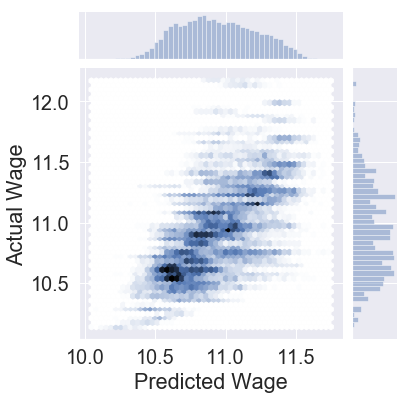

In [235]:
nn = 4
ypred = pd.concat([pd.DataFrame(arall_xfit[nn].y_predict[i]).T for i in range(100)])
ytest = np.concatenate([arall_xfit[nn].y_test[i].values for i in range(100)])
ypred['ytest'] = ytest
predactual_fte = pd.DataFrame(np.concatenate([ypred[[i,'ytest']].values 
                                              for i in range(3)]),columns = ['Predicted Wage','Actual Wage'])
sns.jointplot(x = 'Predicted Wage',y='Actual Wage',data= predactual_fte,kind='hex')

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'PREDICTED INFLUENCE ON WAGE SETTING\n')

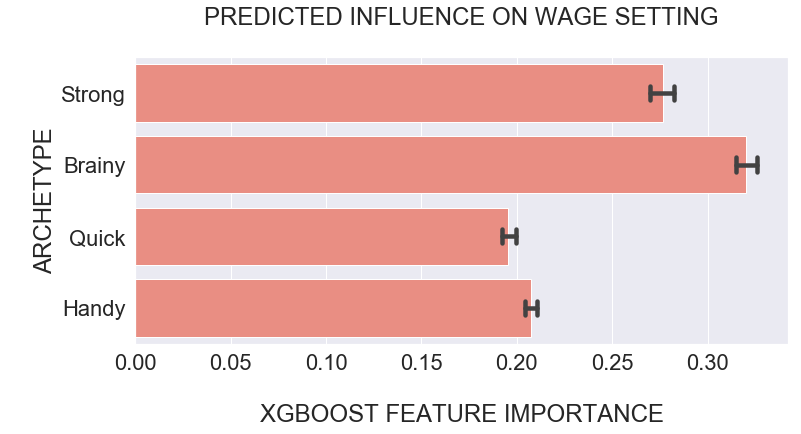

In [302]:
sns.set(rc={'figure.figsize':(11.7,5.27)})
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
data = pd.concat([pd.DataFrame(arall_xfit[4].feature_importances[i],columns = ['Strong','Brainy','Quick','Handy']) for i in range(100)])
sns.barplot(data=data,orient = 'horizontal',capsize = .2,color = 'salmon')
plt.ylabel('\nARCHETYPE')
plt.xlabel('\nXGBOOST FEATURE IMPORTANCE')
plt.title('PREDICTED INFLUENCE ON WAGE SETTING\n')